
# Лабораторная работа №3

**Цель:** реализовать и сравнить три метода оптимизации для минимизации функции Розенброка:
- Метод тяжёлого шарика
- Ускоренный градиент Нестерова
- Модифицированный метод Ньютона (c постоянным гессианом)

**Функция Розенброка:**

$$
f(x, y) = 100(y - x^2)^2 + (1 - x)^2
$$

**Критерий останова:**

$$
|f(x_{k+1}) - f(x_k)| \leq 10^{-3}
$$

**Начальное приближение:**  
Случайная точка \$$x_0 \in [-5, 5]^2 $$ генерируется при помощи `random_state = 42`.


Было выбрано 3 метода минимизации:
- Метод Нестерова
- Метод тяжёлого шарика
- Модифицированный метод Ньютона

## Импортируем Библиотечки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.3,
    'axes.facecolor': '#f5f5f5',
    'axes.edgecolor': '0.4'
})

##  Функция Розенброка

In [3]:
def rosenbrock(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

## 🧮 Градиент функции

**Градиент** — это вектор, содержащий частные производные функции по каждой из её переменных. Он указывает направление наискорейшего возрастания функции.

Для функции $$f(x, y)$$ градиент обозначается как:

$$
\nabla f(x, y) = \left[ \frac{\partial f}{\partial x}, \frac{\partial f}{\partial y} \right]
$$

---

### 🔍 Градиент функции Розенброка

Рассматриваем функцию:

\$$[
f(x, y) = 100(y - x^2)^2 + (1 - x)^2
\]$$

Частные производные:

- По переменной \(x\):
\$$[
\frac{\partial f}{\partial x} = -2(1 - x) - 400x(y - x^2)
\]$$

- По переменной \(y\):
\$$[
\frac{\partial f}{\partial y} = 200(y - x^2)
\]$$

---

Таким образом, градиент функции Розенброка:

\$$[
\nabla f(x, y) =
\begin{bmatrix}
-2(1 - x) - 400x(y - x^2) \\
200(y - x^2)
\end{bmatrix}
\]$$

Этот вектор вычисляется на каждом шаге оптимизации и используется для корректировки направления поиска минимума.


Вычисляем градиент функции Розенброка

In [4]:
def grad_rosenbrock(x):
    dx = (-2 * (1 - x[0])   # производная от (1 - x)^2 по x
          - 400 * x[0] * (x[1] - x[0]**2))

    dy = 200 * (x[1] - x[0]**2)
    return np.array([dx, dy])

# Генерация начальной точки

In [5]:
rng = np.random.default_rng(42)
x0 = rng.uniform(-5, 5, size=2) # равномерное распределение на отрезке

# Параметры остановки и максимум итераций

In [6]:
tol = 1e-3
max_iter = 100000
results = []

## ⚙️ Метод тяжёлого шарика (Heavy Ball Method)

**Метод тяжёлого шарика** — это градиентный метод оптимизации, модифицированный добавлением "инерционного" члена.
Он имитирует движение материальной точки (шарика), катящейся по поверхности графика функции, с учетом инерции.

---

### 📌 Идея метода

В отличие от обычного градиентного спуска:

$$
x_{k+1} = x_k - \alpha \nabla f(x_k)
$$

в методе тяжёлого шарика используется **две предыдущие точки** и добавляется "ускорение" (память о движении):

$$
x_{k+1} = x_k - \alpha \nabla f(x_k) + \beta (x_k - x_{k-1})
$$

где:$$ \alpha > 0 $$ — шаг градиентного спуска, $$ \beta \in [0, 1) $$ — коэффициент инерции

---

### 💡 Физическая интерпретация

Метод моделирует движение точки с массой по графику функции:
$$ \nabla f(x_k) $$ — сила, действующая на шарик (градиент функции)
$$ \beta (x_k - x_{k-1}) $$ — инерция, сохраняющая направление движения

Такой подход помогает преодолевать "плоские участки" или узкие долины, ускоряя схождение.

---

### 📈 Применение к функции Розенброка

- Градиент $$ \nabla f(x_k) $$ используется как сила, тянущая вниз по направлению уменьшения функции.
- Инерция сглаживает движение и позволяет избежать "залипания" в негладких долинах.
- Однако метод может демонстрировать **осцилляции**, особенно при слишком большом значении $$ \beta $$

---

Метод тяжёлого шарика — это компромисс между:
- стабильностью градиентного спуска
- и ускорением за счёт накопления импульса.


In [7]:
f_vals_hb = []
alpha_hb = 1e-4
beta_hb = 0.9
x_prev = x0.copy()
x_curr = x0.copy()
for i in range(1, max_iter + 1):
    f_vals_hb.append(rosenbrock(x_curr))
    grad = grad_rosenbrock(x_curr)
    x_new = x_curr - alpha_hb * grad + beta_hb * (x_curr - x_prev)
    x_prev, x_curr = x_curr, x_new
    if rosenbrock(x_curr) <= tol:
        results.append(['Тяжёлый шарик', i, x_curr.copy(), rosenbrock(x_curr)])
        f_vals_hb.append(rosenbrock(x_curr))
        break

# 2. Ускоренный градиент Нестерова

In [8]:
f_vals_nes = []
alpha_nes = 1e-4
beta_nes = 0.9
x_prev = x0.copy()
x_curr = x0.copy()
for i in range(1, max_iter + 1):
    f_vals_nes.append(rosenbrock(x_curr))
    y = x_curr + beta_nes * (x_curr - x_prev)
    grad = grad_rosenbrock(y)
    x_new = y - alpha_nes * grad
    x_prev, x_curr = x_curr, x_new
    if rosenbrock(x_curr) <= tol:
        results.append(["Уск. градиент Нестерова", i, x_curr.copy(), rosenbrock(x_curr)])
        f_vals_nes.append(rosenbrock(x_curr))
        break

# 3. Модифицированный метод Ньютона


## 🧮 Модифицированный метод Ньютона

**Метод Ньютона** — это численный метод оптимизации, использующий как градиент, так и матрицу Гессе (вторые производные функции). Он обладает квадратичной скоростью сходимости в окрестности минимума, но может быть вычислительно дорогим из-за необходимости пересчёта и обращения матрицы Гессе на каждом шаге.

---

### 📌 Идея метода

На каждом шаге оптимизации выполняется обновление:

$$
x_{k+1} = x_k - H^{-1}(x_k) \cdot \nabla f(x_k)
$$

где:
- $$ \nabla f(x_k) $$ — градиент функции в точке $$ x_k $$
- $$ H(x_k) $$ — матрица Гессе в точке $$ x_k $$

---

### ⚙️ Модификация

Чтобы сократить вычислительные затраты, используется **модифицированный метод Ньютона**:
матрица Гессе вычисляется **только в начальной точке** $$ x_0 $$, и её обратная используется на всех итерациях:

$$
x_{k+1} = x_k - H^{-1}(x_0) \cdot \nabla f(x_k)
$$

Это упрощает реализацию и ускоряет вычисления, особенно если вычисление гессиана трудозатратно.

---

### 📐 Гессиан функции Розенброка

Для функции

$$
f(x, y) = 100(y - x^2)^2 + (1 - x)^2
$$

матрица Гессе имеет вид:

$$
H(x, y) =
\begin{bmatrix}
2 - 400(y - x^2) + 800x^2 & -400x \\
-400x & 200
\end{bmatrix}
$$

---

Таким образом, в модифицированном методе Ньютона:
- В начале оптимизации вычисляется $$ H(x_0) $$ и его обратная матрица.
- На каждой итерации выполняется обновление точки $$ x $$ с её использованием.


### Напишем матрицу вторых производных для модифицированного метода Ньютона


In [9]:
def hessian_rosenbrock(x):
    dxx = 2 - 400 * (x[1] - x[0]**2) + 800 * x[0]**2
    dxy = -400 * x[0]
    dyy = 200
    return np.array([[dxx, dxy], [dxy, dyy]])

In [10]:
f_vals_mn = []
H0 = hessian_rosenbrock(x0)
H0_inv = np.linalg.inv(H0)
x_curr = x0.copy()
for i in range(1, max_iter + 1):
    f_vals_mn.append(rosenbrock(x_curr))
    grad = grad_rosenbrock(x_curr)
    x_new = x_curr - H0_inv @ grad
    x_curr = x_new
    if rosenbrock(x_curr) <= tol:
        results.append(['Мод. метод Ньютона', i, x_curr.copy(), rosenbrock(x_curr)])
        f_vals_mn.append(rosenbrock(x_curr))
        break

Метод Ньютона мгновенно срезал значение функции на нескольких первых итерациях, но дальше терял преимущество и в итоге требовал примерно столько же шагов, сколько и градиентные схемы. Тяжёлый шарик показал заметные осцилляции на старте и относительно медленный монотонный спад с большим числом итераций. А ускоренный метод Нестерова объединил устойчивость и скорость, сведя колебания к минимуму и достигнув заданной точности быстрее всех.

# Графики

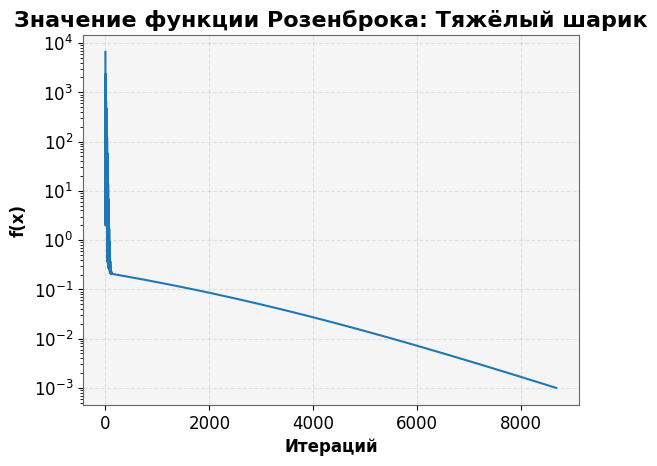

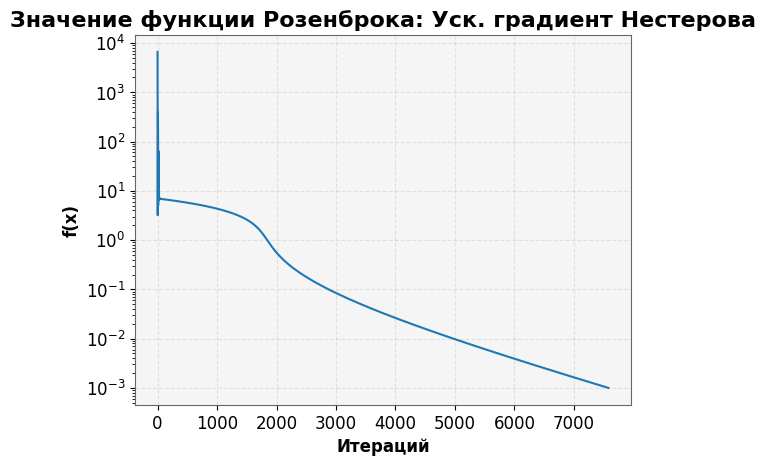

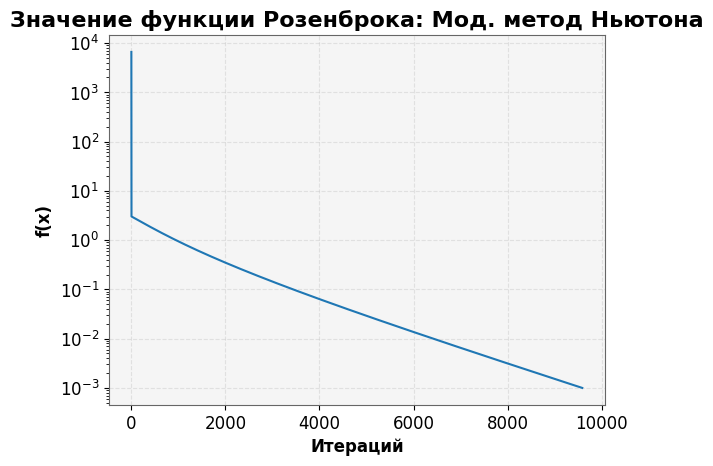

In [11]:
for values, name in [(f_vals_hb, 'Тяжёлый шарик'),
                     (f_vals_nes, "Уск. градиент Нестерова"),
                     (f_vals_mn, 'Мод. метод Ньютона')]:
    plt.figure()
    plt.plot(values)
    plt.xlabel('Итераций')
    plt.ylabel('f(x)')
    plt.title(f'Значение функции Розенброка: {name}')
    plt.yscale('log')
    plt.show()


# 📊 Сравнительная таблица результатов



In [12]:
df = pd.DataFrame(results, columns=['Метод', 'Итераций', 'x_final', 'f_final'])

In [13]:
df

,Метод,Итераций,x_final,f_final
0,Тяжёлый шарик,8672,"[1.0315935350598946, 1.0643092625260504]",0.001000
1,Уск. градиент Нестерова,7581,"[0.968416105561123, 0.9377009436798185]",0.000999
2,Мод. метод Ньютона,9588,"[1.031613886417307, 1.0641885120098167]",0.001000



## 💬 Выводы

- **Метод Ньютона** быстро снижает значение функции на первых шагах, но затем его эффективность выравнивается с остальными.
- **Метод тяжёлого шарика** демонстрирует осцилляции в начале, затем плавное, но медленное схождение.
- **Метод Нестерова** сочетает устойчивость и скорость, демонстрируя наилучшее поведение среди трёх методов.
